# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [2]:
# 从这个路径加载模型
from src.model import Model

model = Model(parameters=cfg)

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

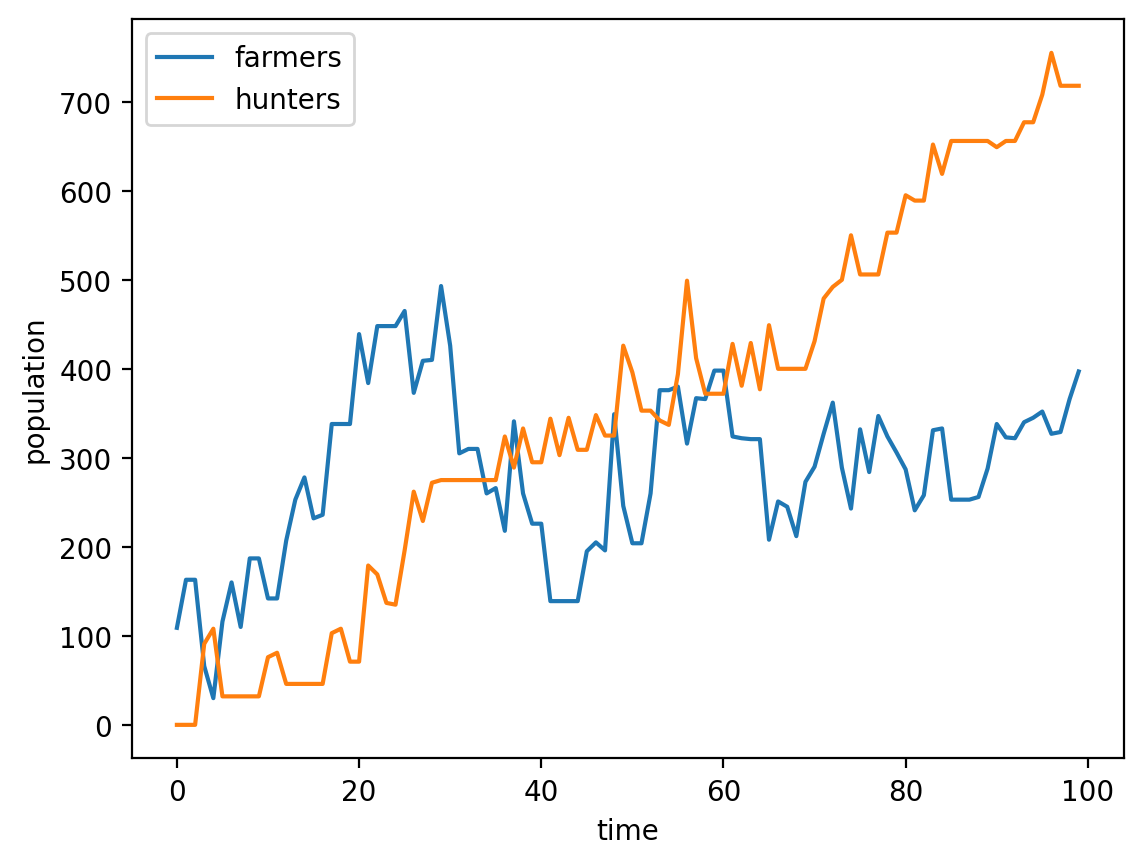

In [3]:
model.run_model()

展示主体的信息

In [4]:
agent = model.agents.to_list().random_choose()
agent.report()

unique_id    114307724830808745832203918265299001126
breed                                         Hunter
size                                               8
position                                   (64, 205)
dtype: object

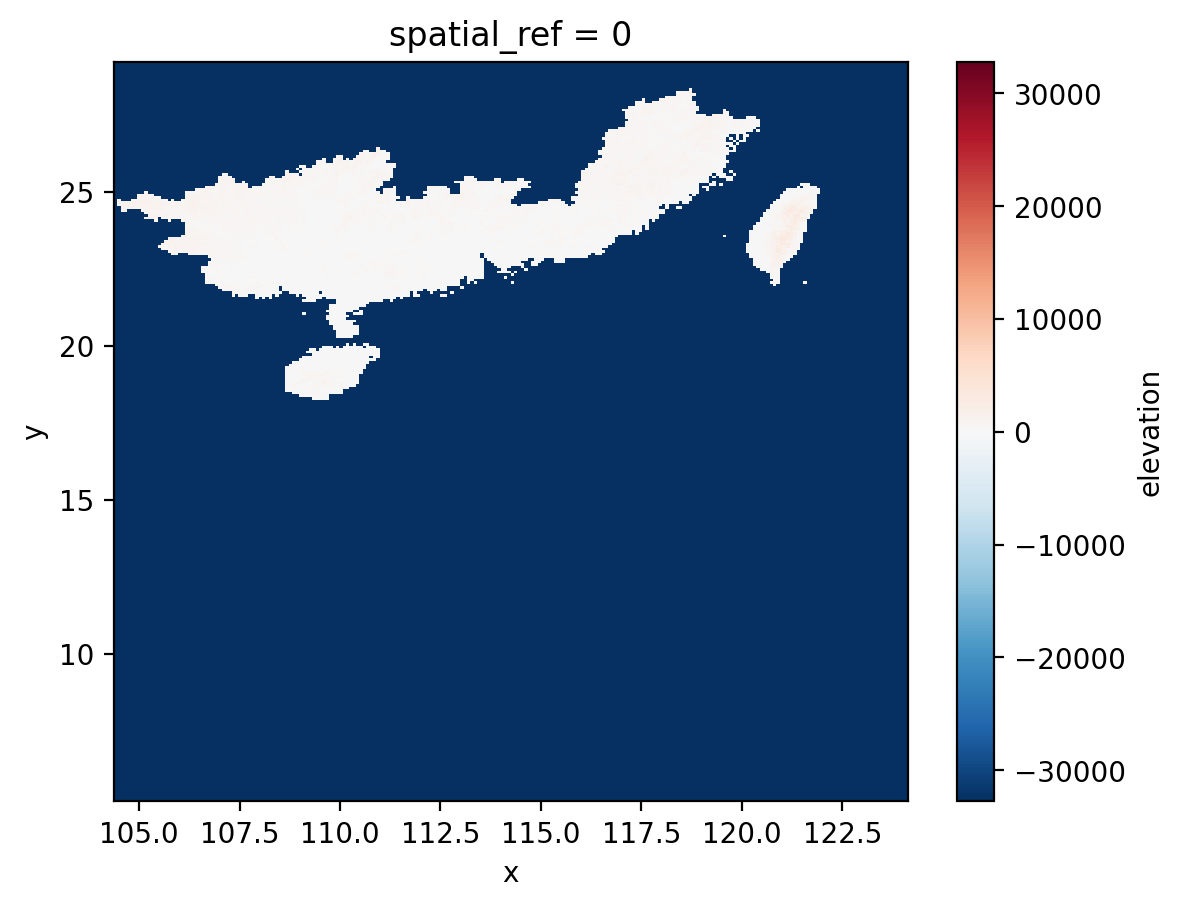

In [6]:
model.nature.dem.get_xarray("elevation").plot()

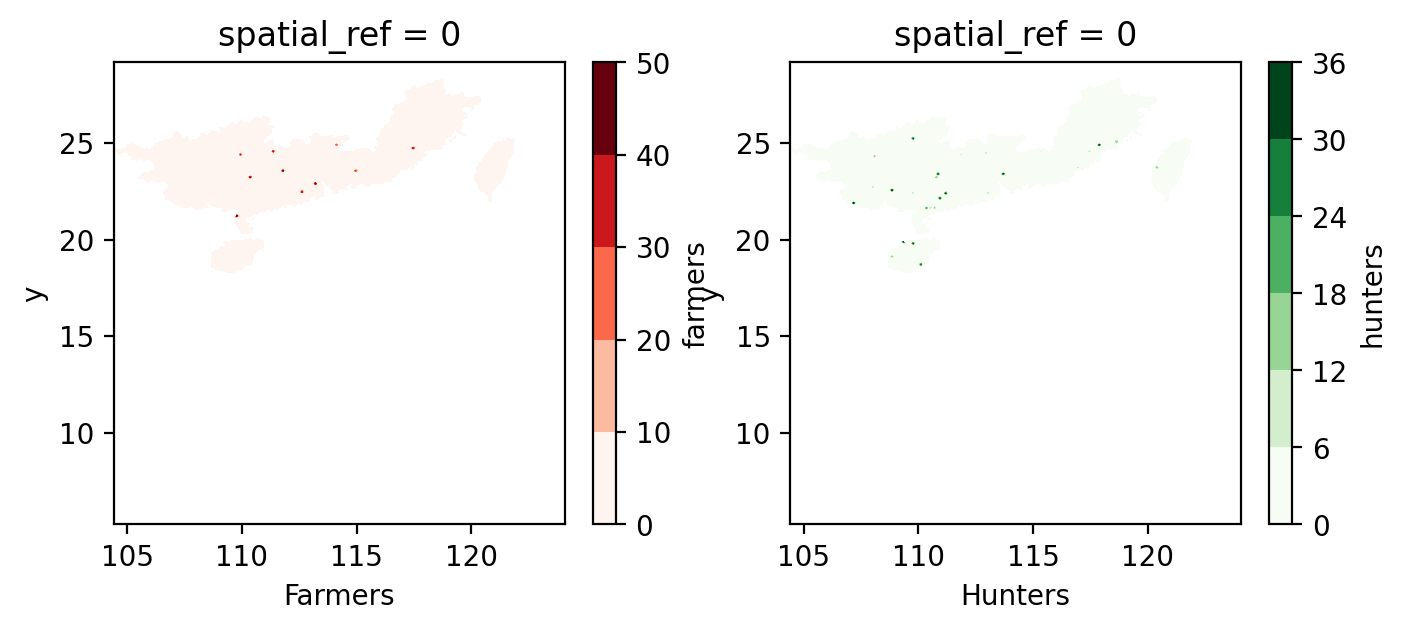

In [10]:
model.heatmap()